# Vanilla elo
---

- 0. Data loading.
- 1. About elo, why its preferred.
- 1.1. Some maths behind it.
- 1.2. Brief history of the nba.

A note about fivethirtyeight and how it inspired me to do this.

- 2. Calculating vanilla elo.
- 2.1. Discuss some results.
- 3. Limitations of vanilla elo, point differential.
- 3.1. Why direct scaling is a bad idea.
- 3.2. Calculation and discussion.
- 4. Why home-court is important.
- 4.1 Adding HCA.
- 4.2 About the 1996-1997 Bulls.
- 5. What elo offers, what it misses(finding a good k-factor), alternatives like Glicko and towards a Bayesian system.

## 0. Data loading and pre-processing.
---

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")

In [3]:
from datetime import datetime, timedelta
from collections import defaultdict

In [4]:
## load data
raw_data = pd.read_csv("/Users/tejaswin.p/Downloads/data_nbaallelo.csv", )
print "Total rows:", len(raw_data)
print "Total columns:", len(raw_data.columns)

Total rows: 126314
Total columns: 23


In [5]:
raw_data.columns

Index([u'gameorder', u'game_id', u'lg_id', u'_iscopy', u'year_id',
       u'date_game', u'seasongame', u'is_playoffs', u'team_id', u'fran_id',
       u'pts', u'elo_i', u'elo_n', u'win_equiv', u'opp_id', u'opp_fran',
       u'opp_pts', u'opp_elo_i', u'opp_elo_n', u'game_location',
       u'game_result', u'forecast', u'notes'],
      dtype='object')

In [6]:
df_data = raw_data[[u'gameorder', u'game_id', u'lg_id', u'_iscopy', u'year_id',
       u'date_game', u'seasongame', u'is_playoffs', u'team_id', u'fran_id',
       u'pts', u'opp_id', u'opp_fran',
       u'opp_pts', u'game_location',
       u'game_result']][raw_data._iscopy==0].copy()

In [7]:
print "Data shape:", df_data.shape

Data shape: (63157, 16)


In [8]:
# df_data.date_game.head(10)

In [9]:
_d = "11/1/1946"
def string_to_datetime(dstring):
    m, d, y = dstring.strip().split('/')
    return datetime(int(y), int(m), int(d))

In [10]:
df_data["game_datetime"] = df_data.date_game.map(string_to_datetime)

### 0.1. Tracking the franchises through time.

In [11]:
_active_franchises = set(df_data[df_data.year_id==2015]["fran_id"])

In [12]:
_tracking_teams = {}
_tracking_data = []
for ix, row in df_data[["team_id", "fran_id", "year_id"]].drop_duplicates().sort_values(["fran_id", "year_id"])[["fran_id", "team_id", "year_id"]].iterrows():
    fran_id, team_id, year_id = row["fran_id"], row["team_id"], row["year_id"]
    if fran_id not in _tracking_teams:
        _tracking_teams[fran_id] = [team_id]
        _tracking_data.append((fran_id, team_id, year_id, fran_id in _active_franchises))
    else:
        if team_id not in _tracking_teams[fran_id]:
            _tracking_teams[fran_id].append(team_id)
            _tracking_data.append((fran_id, team_id, year_id, fran_id in _active_franchises))

pd.options.display.max_rows = 150
pd.DataFrame.from_records(_tracking_data, columns=["Franchise", "Team Name", "Year", "IsActive"]).sort_values(["IsActive", "Franchise", "Year"])

,Franchise,Team Name,Year,IsActive
0,Baltimore,BLB,1948,False
1,Bombers,STB,1947,False
4,Capitols,WSC,1947,False
10,Colonels,KEN,1968,False
11,Condors,PTP,1968,False
12,Condors,MNP,1969,False
13,Condors,PTC,1971,False
14,Denver,DNN,1950,False
15,Falcons,DTF,1947,False
16,Floridians,MNM,1968,False


In [13]:
pd.options.display.max_rows = 60
teams = set(df_data.fran_id).union(set(df_data.opp_fran))
print "Total unique franchises:", len(teams)

Total unique franchises: 53


## 1. The Elo rating.
---
Elo is a rating system for computing the estimated skill of two entities playing against each other. The absolute skill of an entity by itself has no meaning, it only makes sense when compared to another entity's skill. While originally designed for Chess, it has since been modified and applied to many other one-VS-one games and also team games. 

### 1.1. Core assumptions.
- The estimation process is initialised with a base rating(or skill). This is not mandatory - such an assumption implies all player's are equally skilled. In vanilla Elo, the update process is a zero-sum game - i.e. the losing player's decrease in skill is equal to the winning player's gain in skill. 

- Elo assumes that a player's skill is normally distributed around his *true* skill rating - a reasonable assumption to make since an overwhelming number of natural and social-science phenomenon can be modelled rather accurately with normal distributions. The "consistency" of the player's performance on game days is dependent on the variance of the distribution. It follows, that the difference in skills is also normally distributed, with the mean as the difference of means and the uncertainity as the combined uncertainity of the original entities.

- Consider for example, a game between two players $a$ and $b$ with base ratings 1000 and 800 respectively (the variances are assumed to be 100 for both).

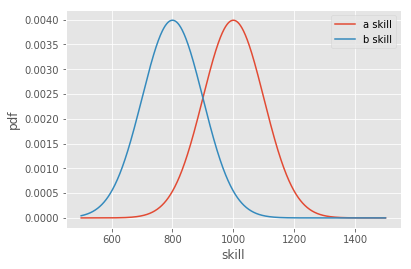

In [14]:
from scipy.stats import norm
a = norm(1000, 100)
b = norm(800, 100)
xs = np.linspace(500, 1500, 1000)
plt.plot(xs, a.pdf(xs), label="a skill")
plt.plot(xs, b.pdf(xs), label="b skill")
plt.xlabel("skill")
plt.ylabel("pdf")
plt.legend();

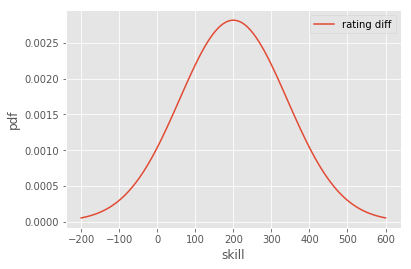

In [15]:
abd = norm(200, np.sqrt(20000))
xs = np.linspace(-200, 600, 100)
plt.plot(xs, abd.pdf(xs), label="rating diff")
plt.xlabel("skill")
plt.ylabel("pdf")
plt.legend();

- The change in ratings after the game is a function of the expected outcome before the game. If the outcome is aligned with the exptected outcome before the game, then the change in ratings is minimal. Conversely, if the outcome is a huge upset, then it will be reflected in the update.

- While the expected value of the outcome can be calculated from the normal above by taking the area under the curve after 0, Elo uses a sigmoid function for the updates. The exact equations are mentioned below.

- Vanilla Elo only depends on the outcome. If a game involves some sort of spread or point differential, that does not factor in the updates.

### 1.2. Computing Elo.
For 2 players $A$ and $B$, with ratings $R_A$ and $R_B$ respectively, the expected winning probability of $A$ is defined as:

\begin{align}
E_A & = \frac{1}{1 + 10^{{(R_B - R_A)}/400}} \\
E_B & = 1 - E_A \\
\end{align}

With the expected score $E_A$ and the true outcome $S_A$, the updated ratings are defined as follows:

\begin{align}
R'_A & = R_A + K(S_A - E_A) \\
R'_B & = R_B + K(1 - S_A - E_A) \\
\end{align}

$K$ is the scale factor which determines how much skill[points?] will be exchanged in the updates.

### 1.3. Elo's popularity.
Elo's simplicity lends it's popularity. For a fixed $K$ factor(which can be computed mechanically by selecting a $K$ which returns the highest "goodness" metric), the sytem only needs to track and update a single parameter for every participant. Another reason for its popularity is that it can be extended to include to include other signals in the updates. We shall see how it can be extended to include points spread(if available) as well as home-court-advantage(if applicable). 

### 1.4. Application to the nba.
The National Basketball Association - originally the Basketball Association of America - was founded in 1946. The league was renamed NBA after it's merger with the National Basketnall league. While currently, it consists of 30 different franchises, some of these have changed their names and even home ground over the years. These changes have been accounted for in the data. Every game is played between 2 franchises and there are no draws. The team with the most points after time wins. And while the Vanilla Elo discards the point differential a well as the home-court advantage, we'll discuss how that can be included.

For the 3 versions of Elo discussed here (vanilla, point differential, point diff + home-court-advantage), every team starts with a base rating of 1500 and gets updated after every match till the end of the season. Warriors fans should forgive me for not including the 2016 season where they beat the '97 Bulls regular season record with 73 wins and 9 losses.

In [16]:
# df_data.head()

In [17]:
# first, set everything to 0
df_data["prev_fran_elo"] = 0.0
df_data["prev_opp_elo"] = 0.0
df_data["new_fran_elo"] = 0.0
df_data["new_opp_elo"] = 0.0

In [18]:
# next, for all the FIRST games of the season, set the previous ELO rating to 1500
vanilla_elo = defaultdict(list)
for fran in teams:
    vanilla_elo[fran].append(1500)

In [19]:
def update_elo(home, away, outcome, k=20):
    exp_home = 1.0 / (1.0 + 10**((away - home)/400.0) )
    exp_away = 1.0 - exp_home
    
    r_home = home + k*(outcome - exp_home)
    r_away = away + k*(1 - outcome - exp_away)
    
    return r_home, r_away

In [20]:
from time import time

In [21]:
_StartTime = time()
_counter = 0
print "\nComputing vanilla Elo...\n"

for ix,row in df_data.sort_values("game_datetime").iterrows():
    _counter += 1
    if _counter%5000==0:
        print "Completed %d games."%_counter
    
    outcome = 1 if row["game_result"]=='W' else 0
    
    fran, opp = row["fran_id"], row["opp_fran"]
    prev_fran_elo, prev_opp_elo = vanilla_elo[fran][-1], vanilla_elo[opp][-1]
    
    new_fran_elo, new_opp_elo = update_elo(prev_fran_elo, prev_opp_elo, outcome)
    vanilla_elo[fran].append(new_fran_elo)
    vanilla_elo[opp].append(new_opp_elo)
    
    df_data.loc[ix, "prev_fran_elo"] = prev_fran_elo
    df_data.loc[ix, "prev_opp_elo"] = prev_opp_elo
    
    df_data.loc[ix, "new_fran_elo"] = new_fran_elo
    df_data.loc[ix, "new_opp_elo"] = new_opp_elo


print "Completed %d games."%_counter
print "\nDone.", "Time :", (time()-_StartTime)/60.0, "mins."


Computing vanilla Elo...

Completed 5000 games.
Completed 10000 games.
Completed 15000 games.
Completed 20000 games.
Completed 25000 games.
Completed 30000 games.
Completed 35000 games.
Completed 40000 games.
Completed 45000 games.
Completed 50000 games.
Completed 55000 games.
Completed 60000 games.
Completed 63157 games.

Done. Time : 2.07215496699 mins.


In [22]:
# df_data.sort_values("game_datetime").head(25)

### 1.6. Results.

In [40]:
print "Top 25 teams of all time...upto the 2015-2016 season."
sorted(
    [(k,v[-1]) for k,v in vanilla_elo.iteritems()], reverse=True, key=lambda x: x[1]
)[:25]

Top 25 teams of all time...upto the 2015-2016 season.


[('Warriors', 1838.4004693273725),
 ('Spurs', 1734.0129955616374),
 ('Cavaliers', 1729.9401228056909),
 ('Clippers', 1725.4892593191162),
 ('Rockets', 1721.763919053845),
 ('Grizzlies', 1689.6744384883434),
 ('Hawks', 1640.9349415637537),
 ('Thunder', 1628.7855075441337),
 ('Mavericks', 1622.1097941848834),
 ('Colonels', 1609.8813665977987),
 ('Bulls', 1606.8632887299254),
 ('Trailblazers', 1595.157507671492),
 ('Wizards', 1591.2140961176096),
 ('Pelicans', 1585.9411137391965),
 ('Stags', 1567.7626395624277),
 ('Pacers', 1563.766264297583),
 ('Jazz', 1562.1789222290483),
 ('Packers', 1557.9122669334454),
 ('Nets', 1552.2851267765707),
 ('Celtics', 1547.9920659663067),
 ('Raptors', 1539.126409613078),
 ('Olympians', 1532.5492414340606),
 ('Suns', 1529.6868165153774),
 ('Heat', 1518.3032170200295),
 ('Bucks', 1503.4002806396702)]

Some expected results in the top 25 list. The top team(GSW) was the current chapmion(this data is upto 2015-2016), the 2nd best team(SAS) was the previous year's champion and the 3rd best team(CLE) will go on to be the next year's champion thanks to [Draymond Green's "sentient" leg](http://ftw.usatoday.com/2016/12/draymond-green-kicks-james-harden-warriors-rockets).

Below are the ratings of a few selected teams over time. FYI, I did not pick purple for the Lakers... it just happened to be the 4th color which Matplotlib picked.

In [23]:
def plot_ratings(df, elo_data, franchise, spit=False):
    _x, _y = df[(df.fran_id==franchise) | (df.opp_fran==franchise)]["game_datetime"], elo_data[franchise][1:]
    if spit:
        return (_x, _y, franchise)
    
    plt.plot(_x, _y, label=franchise)

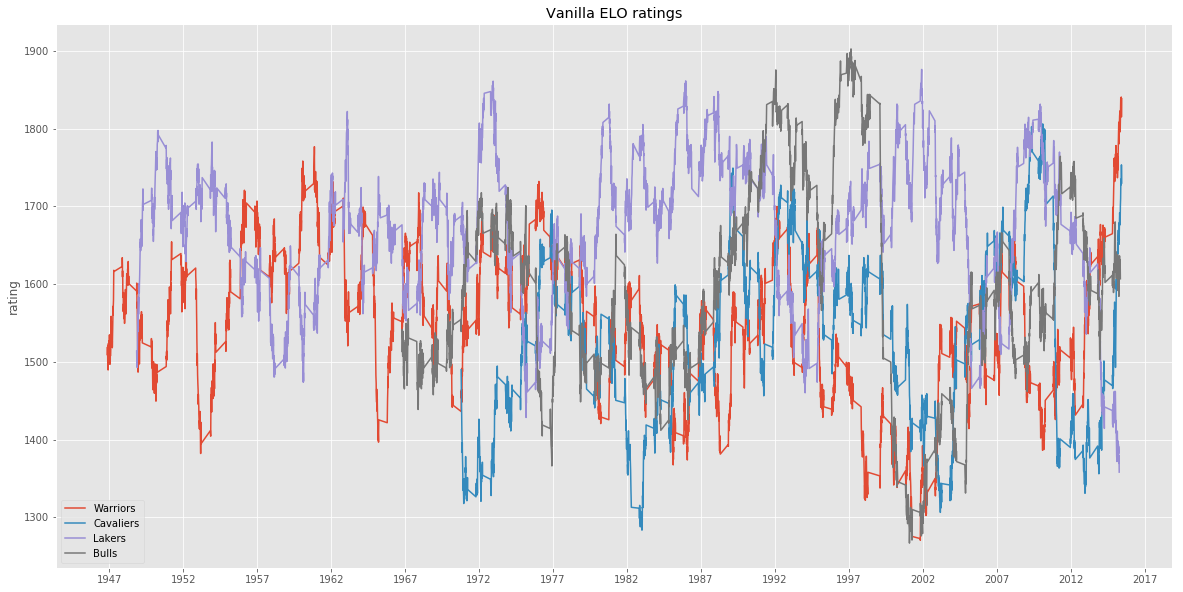

In [21]:
plt.figure(figsize=(20, 10))

plot_ratings(df_data, vanilla_elo, "Warriors")
plot_ratings(df_data, vanilla_elo, "Cavaliers")
plot_ratings(df_data, vanilla_elo, "Lakers")
plot_ratings(df_data, vanilla_elo, "Bulls")

plt.ylabel("rating")
plt.title("Vanilla ELO ratings")
plt.xticks(map(str, range(1947, 2018, 5)))
plt.legend(loc="lower left");

## 2. Point differential.
---
Vanilla Elo does not account for the spread. A simple extension could be to modify the $K$ factor so as to account for the margin of victory. A naive approach could be to multiply $K$ with the point difference but that would make the updates very volatile. Another solution could be to replace it with $K(1 + f(pd))$ where $f(pd)$ is a monotonically increasing function in the points difference $pd$.

In [24]:
df_points = raw_data[[u'gameorder', u'game_id', u'lg_id', u'_iscopy', u'year_id',
       u'date_game', u'seasongame', u'is_playoffs', u'team_id', u'fran_id',
       u'pts', u'opp_id', u'opp_fran',
       u'opp_pts', u'game_location',
       u'game_result']][raw_data._iscopy==0].copy()

Plotting the spread distribution over every NBA game.
Spread mean: 10.7615466219


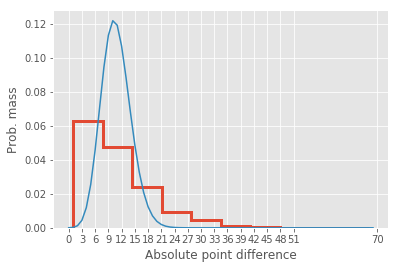

In [25]:
print "Plotting the spread distribution over every NBA game."
df_points["spread"] = np.abs(df_points.pts - df_points.opp_pts)
plt.hist(df_points.spread, bins=10, histtype="step", linewidth=3, normed=True)

from scipy.stats import poisson
print "Spread mean:", df_points.spread.mean()

plt.xticks(range(0, 52, 3) + [70])
plt.xlabel("Absolute point difference")
plt.ylabel("Prob. mass");

d10 = poisson(10.76154)
plt.plot(range(70), d10.pmf(range(70)));

In [26]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

Plotting the spread difference as a sigmoid function.


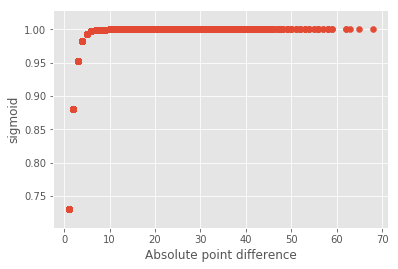

In [27]:
print "Plotting the spread difference as a sigmoid function."
plt.scatter(np.abs(df_points.spread), sigmoid(np.abs(df_points.spread) ))
plt.ylabel("sigmoid")
plt.xlabel("Absolute point difference");

$sigmoid$ could be a possible candidate, but a difference beyond 5 just gets lost in that top space near 1.

Plotting the spread difference as a log function.


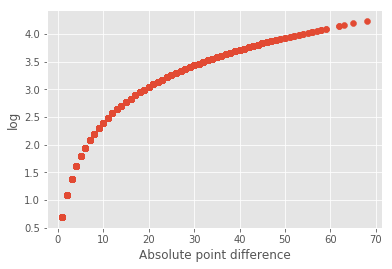

In [28]:
print "Plotting the spread difference as a log function."
plt.scatter(np.abs(df_points.spread), np.log(np.abs(df_points.spread) + 1.0))
plt.ylabel("log")
plt.xlabel("Absolute point difference");

The `log` transform seems to work. Directly multiplying that with the k-factor will account for the margin of victory. What this does not account for is the domanance of one team over the other. That has to be some function of the elo difference. Specifically, if the champions (with an extremely high elo rating; 1996-1997 Bulls) sweep the last standing team before the playoffs (think pre 2017 "tanking"Lakers) then the Bulls should not be awarded a huge factor just because they swept a team as bad as the Lakers. Similarly, if the Lakers were to beat the Bulls, then they should not get a huge reward (since the outcome was probably a fluke). Such a strategy will prevent a favourite's rating from being inflated.

In [29]:
df_data["elo_diff"] = df_data.new_fran_elo - df_data.new_opp_elo

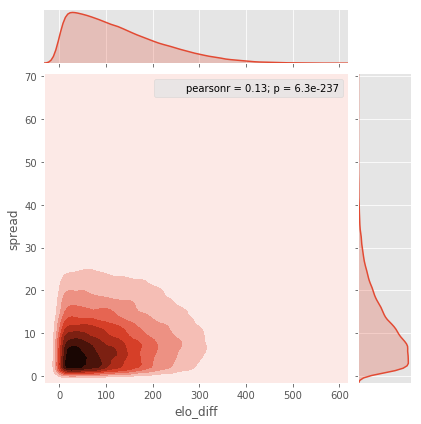

In [28]:
sns.jointplot(np.abs(df_data.elo_diff), np.abs(df_points.spread), kind="kde");

fivethirtyeight uses the following function for scaling $K$
```
def scale_mov(elodiff, pointdiff): ## scale using margin-of-victory
    return np.log(np.abs(pointdiff) + 1) * (2.5 / (elodiff*0.001 + 5))
```
We can see it's effects by running it on some sample scenarios.

In [30]:
diff = 500
pointdiff = 20
scaling = np.log(pointdiff+1)

def scale_mov(elodiff, pointdiff):
    return np.log(np.abs(pointdiff) + 1) * (2.5 / (elodiff*0.001 + 5))

In [31]:
# scale_mov(500, 20), scale_mov(-500, 20)
## (1.3838738353288287, 1.6914013542907906)

In [32]:
print "Using scale_mov"
print "Bulls win by 20:", update_elo(1800, 1300, 1, k=(20*scale_mov(500, 20)) )
print "Lakers win by 10:", update_elo(1800, 1300, 0, k=(20*scale_mov(-500, 10)) )

Using scale_mov
Bulls win by 20: (1801.473554816107, 1298.526445183893)
Lakers win by 10: (1774.7752131950815, 1325.2247868049185)


In [33]:
print "Using log scale"
print "Bulls win by 20:", update_elo(1800, 1300, 1, k=20*np.log(20+1) )
print "Lakers win by 10:", update_elo(1800, 1300, 0, k=20*np.log(10+1) )

Using log scale
Bulls win by 20: (1803.2418205954357, 1296.7581794045643)
Lakers win by 10: (1754.5953837511465, 1345.4046162488535)


In [34]:
print "Without mov(vanilla)"
print "Bulls win by 20:", update_elo(1800, 1300, 1, )
print "Lakers win by 5:", update_elo(1800, 1300, 0, )

Without mov(vanilla)
Bulls win by 20: (1801.0648043040405, 1298.9351956959595)
Lakers win by 5: (1781.0648043040405, 1318.9351956959595)


Notice that the mov scaling for an favourite does not drasitcally change the updated elo rating for a sweep: new ratings for Bulls with scaling is 1801.47 and vanilla is 1801.06.

The impact is observed during a massive upset. If the Lakers win by 10, then they get a bigger update using the mov-scaling: 1325 as opposed to 1318.

It's interesting to note that the 2nd factor in the `def:scale_mov` function almost acts like a beta estimate of the elo difference; that is to say: okay, given that we know that these two teams are pretty far apart in their ratings, should I really award a huge update to either? The logic is that for two teams who have established ratings after consistent performances, a sweep should be routine and thus should have no effect on the updates. Similarly, an upset b/w to two should be dismissed as a fluke.

This behaviour can be controlled, to some capacity, by that 2nd factor in the `def:scale_mov` function. The more you increase the denominator(add to 5), the harder it will be for an underdog to get a bigger update EVEN after pulling off a big upset. 

Part of this is due to the nature of elo updates. By design, elo only looks at the previous ratings, and calculates the expected value of winning based on that. This is also why people go to great lengths for selecting a good k-factor: a common strategy is to have a larger k-factor in the beginning since updating ratings with a very small factor will take time to reflect the true ratings. However, since a large k-factor will lead to volatility, people scale down the k-factor as time passes(or after n games). 

In [35]:
df_points["game_datetime"] = df_points.date_game.map(string_to_datetime)

In [36]:
df_points["prev_fran_elo"] = 0.0
df_points["prev_opp_elo"] = 0.0
df_points["new_fran_elo"] = 0.0
df_points["new_opp_elo"] = 0.0

In [37]:
points_elo = defaultdict(list)
for fran in teams:
    points_elo[fran].append(1500)

In [38]:
_StartTime = time()
_counter = 0
print "\nComputing margin-of-victory Elo...\n"

for ix,row in df_points.sort_values("game_datetime").iterrows():
    _counter += 1
    if _counter%5000==0:
        print "Completed %d games."%_counter
    
    outcome = 1 if row["game_result"]=='W' else 0
    
    fran, opp = row["fran_id"], row["opp_fran"]
    prev_fran_elo, prev_opp_elo = points_elo[fran][-1], points_elo[opp][-1]
    
    new_fran_elo, new_opp_elo = update_elo(prev_fran_elo, prev_opp_elo, outcome, 
                                           k=20*scale_mov(elodiff=prev_fran_elo-prev_opp_elo, 
                                                          pointdiff=row["spread"]))
    points_elo[fran].append(new_fran_elo)
    points_elo[opp].append(new_opp_elo)
    
    df_points.loc[ix, "prev_fran_elo"] = prev_fran_elo
    df_points.loc[ix, "prev_opp_elo"] = prev_opp_elo
    
    df_points.loc[ix, "new_fran_elo"] = new_fran_elo
    df_points.loc[ix, "new_opp_elo"] = new_opp_elo

print "Completed %d games."%_counter
print "\nDone.", "Time :", (time()-_StartTime)/60.0


Computing margin-of-victory Elo...

Completed 5000 games.
Completed 10000 games.
Completed 15000 games.
Completed 20000 games.
Completed 25000 games.
Completed 30000 games.
Completed 35000 games.
Completed 40000 games.
Completed 45000 games.
Completed 50000 games.
Completed 55000 games.
Completed 60000 games.
Completed 63157 games.

Done. Time : 2.18449503581


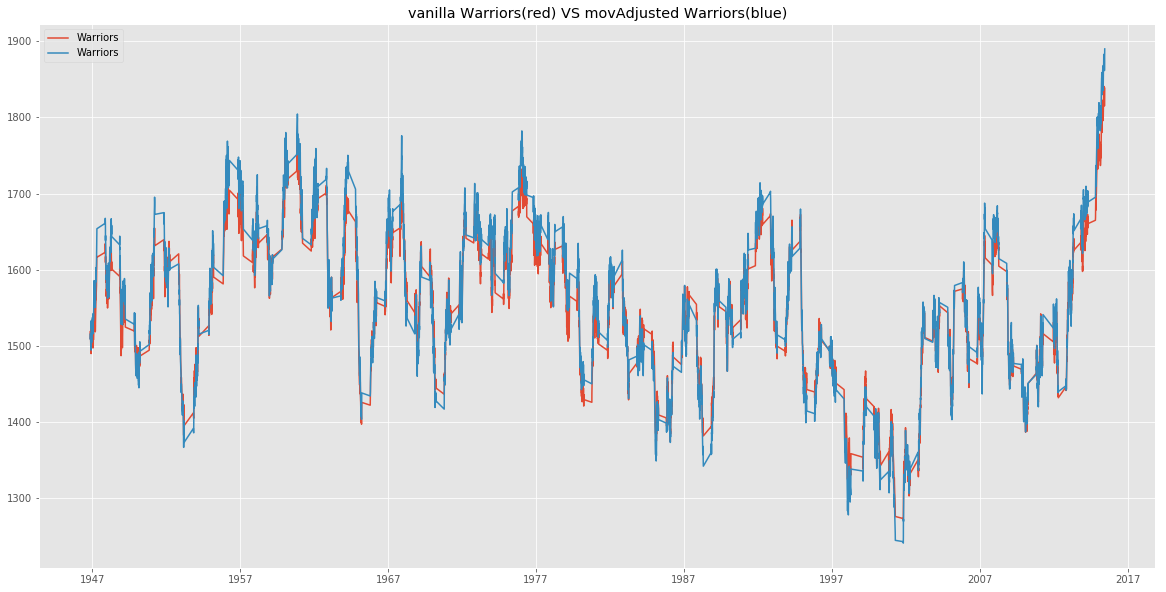

In [59]:
plt.figure(figsize=(20, 10))

plot_ratings(df_data, vanilla_elo, "Warriors")
plot_ratings(df_points, points_elo, "Warriors")
# plt.plot(df_points[(df_points.fran_id=="Warriors") | (df_points.opp_fran=="Warriors")]["game_datetime"],
#         points_elo["Warriors"][1:], label="Warriors-mov")
# plt.plot(df_points[(df_points.fran_id=="Cavaliers") | (df_points.opp_fran=="Cavaliers")]["game_datetime"],
#         points_elo["Cavaliers"][1:], label="Cavaliers-mov")


plt.legend()
plt.title("vanilla Warriors(red) VS movAdjusted Warriors(blue)");

### 3. Adding home-court advantage.
---
Like most sports, the home-court plays a big role in the NBA. In fact, of the two conference champions who reach the best of 7 finals, the one with the better record gets to play at their home first, thereby giving them home-court advantage in the final game 7. Up until 2013, the format was HH-AAA-HH. Since then, it has been changed to HH-AA-H-A-H. 

*How big of an advantage you ask?*

In [39]:
# df_points.groupby("game_location").count()
result = """
gameorder	game_id	lg_id	_iscopy	year_id	date_game	seasongame	is_playoffs	team_id	fran_id	...	opp_id	opp_fran	opp_pts	game_result	spread	game_datetime	prev_fran_elo	prev_opp_elo	new_fran_elo	new_opp_elo
game_location																					
H	63138	63138	63138	63138	63138	63138	63138	63138	63138	63138	...	63138	63138	63138	63138	63138	63138	63138	63138	63138	63138
N	19	19	19	19	19	19	19	19	19	19	...	19	19	19	19	19	19	19	19	19	19
2 rows × 21 columns
"""

In [70]:
print "The magic number is %.2f"%round(len(df_points[(df_points.game_location=="H") & (df_points.game_result=="W")]) * 1.0/len(df_points) * 100, 2)

The magic number is 62.23


62.23% of all results, came from a home win. For (nearly)equally matched teams, the expectations to win must be identical. In such cases, the HCA (home-court-advantage) could give an edge to the home team. In fact, this "edge" must result in (on average) a net 62% chance of winning for the home team. 

Elo diff 	Expectation of winning
86 		0.621296723122
87 		0.622650195787
88 		0.624001758618
89 		0.625351393308
90 		0.626699081667
91 		0.628044805622
92 		0.629388547218


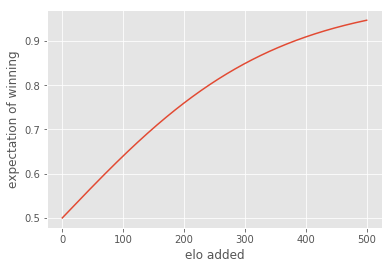

In [40]:
exp_new = []
for ediff in range(0, 501):
    home, away = 1500, 1500
    home = home + ediff
    exp_home = 1.0 / (1.0 + 10**((away - home)/400.0) )
    exp_new.append(exp_home)

plt.plot(range(0, 501), exp_new)
plt.xlabel("elo added")
plt.ylabel("expectation of winning");

print "Elo diff", "\t", "Expectation of winning"
for ix,val in enumerate(exp_new):
    if val>=0.62 and val<0.63:
        print ix,"\t\t", val

The sigmoid like plot tells that no difference in elo ratings(X axis == 0) will result in 50% chance of winning. The 62.2% we are looking for translates to an additional 87 elo rating points.

In [41]:
hca_points_elo = defaultdict(list)
for fran in teams:
    hca_points_elo[fran].append(1500)

In [42]:
df_hca_points = df_points.copy()

In [43]:
# np.seterr(all='print')

In [44]:
_StartTime = time()
_counter = 0

print "\nAnd now, for the final time... computing HCA+MOV Elo...\n"
for ix,row in df_hca_points.sort_values("game_datetime").iterrows():
    _counter += 1
    if _counter%5000==0:
        print "Completed %d games."%_counter
    
    outcome = 1 if row["game_result"]=='W' else 0
    
    fran, opp = row["fran_id"], row["opp_fran"]
    prev_fran_elo, prev_opp_elo = hca_points_elo[fran][-1], hca_points_elo[opp][-1]
    
    new_fran_elo, new_opp_elo = update_elo(prev_fran_elo, prev_opp_elo, outcome, 
                                           k=20*scale_mov(elodiff=87 + prev_fran_elo-prev_opp_elo, 
                                                          pointdiff=row["spread"]))
    hca_points_elo[fran].append(new_fran_elo)
    hca_points_elo[opp].append(new_opp_elo)
    
    df_hca_points.loc[ix, "prev_fran_elo"] = prev_fran_elo
    df_hca_points.loc[ix, "prev_opp_elo"] = prev_opp_elo
    
    df_hca_points.loc[ix, "new_fran_elo"] = new_fran_elo
    df_hca_points.loc[ix, "new_opp_elo"] = new_opp_elo

print "Completed %d games."%_counter
print "\nDone.", "Time :", (time()-_StartTime)/60.0


And now, for the final time... computing HCA+MOV Elo...

Completed 5000 games.
Completed 10000 games.
Completed 15000 games.
Completed 20000 games.
Completed 25000 games.
Completed 30000 games.
Completed 35000 games.
Completed 40000 games.
Completed 45000 games.
Completed 50000 games.
Completed 55000 games.
Completed 60000 games.
Completed 63157 games.

Done. Time : 2.18165840308


'97 Bulls just REKT the entire plot.


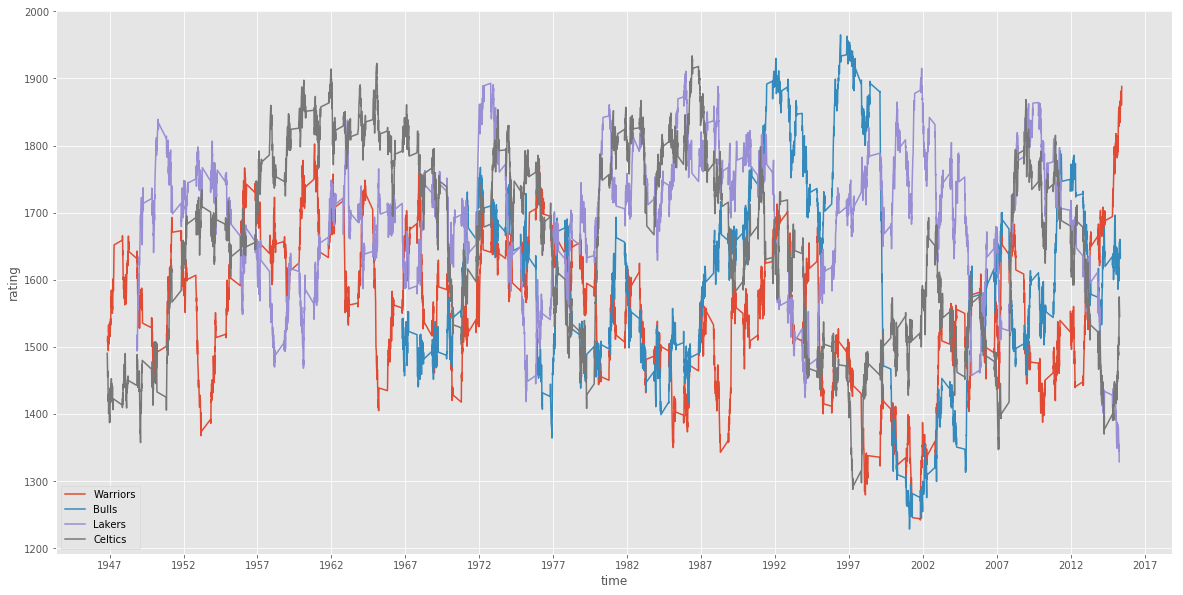

In [101]:
plt.figure(figsize=(20, 10))

# plot_ratings(df_data, vanilla_elo, "Warriors")
# plot_ratings(df_points, points_elo, "Warriors")
plot_ratings(df_hca_points, hca_points_elo, "Warriors")
plot_ratings(df_hca_points, hca_points_elo, "Bulls")
plot_ratings(df_hca_points, hca_points_elo, "Lakers")
plot_ratings(df_hca_points, hca_points_elo, "Celtics")

plt.legend()
plt.xlabel("time")
plt.ylabel("rating")
plt.xticks(map(str, range(1947, 2018, 5)))
plt.legend(loc="lower left");

print "'97 Bulls just REKT the entire plot."

In [41]:
yoy_elo_ratings = defaultdict(dict)
for ix, row in df_hca_points.sort_values("game_datetime").iterrows():
    year = int(row["year_id"])
    fran, opp = row["fran_id"], row["opp_fran"]
    
    yoy_elo_ratings[year][fran] = row["new_fran_elo"]
    yoy_elo_ratings[year][opp] = row["new_opp_elo"]

In [42]:
_years = []
_mean_ratings = []

for year, ratings_dict in yoy_elo_ratings.iteritems():
    _years.append(year)
    _mean_ratings.append(np.mean(ratings_dict.values()))

In [43]:
# plt.figure(figsize=(20, 10))
# plt.plot(_years, _mean_ratings)
# plt.ylabel("Avg elo for all teams at the end of the season.");
# print "Average elo over time:", np.mean(_mean_ratings)

# TODO
Modify the plots from http://nbviewer.jupyter.org/github/jakevdp/mpld3/blob/master/notebooks/interactive_legend.ipynb to create an interactive plot highlighting the key points for the 4 franchises in the last plot.

In [45]:
import mpld3
from mpld3 import plugins
from mpld3.utils import get_id

In [46]:
from IPython.core.debugger import set_trace
def date_to_np(year_date):
    return np.datetime64(year_date)

In [59]:
imp_warriors = [
    (date_to_np("1946"), "Founded and won inaugural title"),
    (date_to_np("1955"), "2nd title"),
    (date_to_np("1959"), "+Chamberlain"),
    (date_to_np("1962"), "Wilt scores 100"),
    (date_to_np("1965"), "-Chamberlain"),
    (date_to_np("1974"), "3rd title"),
    (date_to_np("1990"), "Run T.M.C."),
    (date_to_np("2009"), "+Curry"),
    (date_to_np("2011"), "+Thomspson"),
    (date_to_np("2012"), "+Green"),
    (date_to_np("2014"), "Signed coach Kerr"),
    (date_to_np("2015"), "4th Title")
]

imp_data = [imp_warriors]

In [64]:
def get_first_index(t, x):
    for ix, ts in enumerate(x):
        if ts.to_pydatetime().year == t.astype(object).year:
            ret_val = ix
    return ret_val # returning the last rating for the year!!

In [65]:
### My plotting code.
# xw, yw = pickle.load(open("media/xw.cpkl")), pickle.load(open("media/yw.cpkl"))
# xb, yb = pickle.load(open("media/xb.cpkl")), pickle.load(open("media/yb.cpkl"))
# labels = ["GSW", "CHI"]

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(2,1,1) # timeseries
ax2 = fig.add_subplot(2,1,2) # specific points

labels = ["Warriors"]#, "Bulls", "Lakers", "Celtics"]

l1 = []
s1 = []
for ix, frname in enumerate(labels):
    x, y, _ = plot_ratings(df_hca_points, hca_points_elo, frname, spit=True)
    l1.extend(ax1.plot(x, y, lw=2))

    pointsx, labelsy = [tup[0] for tup in imp_data[ix]], [tup[1] for tup in imp_data[ix]]
    score_indices = [get_first_index(t, x) for t in pointsx]
    
    s1.extend(ax2.plot(pointsx, np.array(y)[score_indices], 'o', ms=8))
    
ilp = plugins.InteractiveLegendPlugin(zip(l1, s1), [l[0] for l in labels], start_visible=False)
plugins.connect(fig, ilp)
mpld3.display()

In [153]:
np.array(xw)

array(['1946-11-07T00:00:00.000000000', '1946-11-14T00:00:00.000000000',
       '1946-11-19T00:00:00.000000000', ...,
       '2015-06-11T00:00:00.000000000', '2015-06-14T00:00:00.000000000',
       '2015-06-16T00:00:00.000000000'], dtype='datetime64[ns]')

In [61]:
pointsx[0].astype(object).year

1946

In [52]:
testts = np.datetime64('1946')

In [54]:
testts.astype(object).year

1946

In [145]:
import cPickle as pickle

In [147]:
pickle.dump(xw, open("media/xw.cpkl", 'w'))

In [148]:
pickle.dump(yw, open("media/yw.cpkl", 'w'))

In [149]:
pickle.dump(xb, open("media/xb.cpkl", 'w'))

In [150]:
pickle.dump(yb, open("media/yb.cpkl", 'w'))

In [151]:
!ls -lhtr media/

total 7928
-rw-r--r--@ 1 tejaswin.p  1493847943   9.5K Dec 24 12:05 clutter_problem_factor_graph.png
-rw-r--r--@ 1 tejaswin.p  1493847943   104K Dec 26 03:40 gaussian_relations_photo.png
-rw-r--r--  1 tejaswin.p  1493847943   510K Dec 29 01:44 test.gif
-rw-r--r--  1 tejaswin.p  1493847943   2.0M Dec 29 11:24 theta_adf.gif
-rw-r--r--  1 tejaswin.p  1493847943   473K Jan  5 22:08 xw.cpkl
-rw-r--r--  1 tejaswin.p  1493847943   232K Jan  5 22:08 yw.cpkl
-rw-r--r--  1 tejaswin.p  1493847943   361K Jan  5 22:08 xb.cpkl
-rw-r--r--  1 tejaswin.p  1493847943   176K Jan  5 22:08 yb.cpkl
